In [187]:
import pandas as pd
from glob import glob
import os
import numpy as np
import re
import sys
from collections import defaultdict
import itertools
sys.path.append('utils/')
from airforce_python_scraper import states
from fuzzywuzzy import fuzz

In [2]:
ls ../data/sapro/SAPRO\ Annual\ Reports

SAPRO_13_all.xlsx          SAPRO_2015/
SAPRO_14_all.xlsx          SAPRO_2016/
SAPRO_15_all.xlsx          SAPRO_all.xlsx
SAPRO_16_all.xlsx          SAPRO_charts_army_14.xlsx
SAPRO_2013/                misc/
SAPRO_2014/


In [3]:
ls ../data/sapro/SAPRO\ Annual\ Reports/SAPRO_2015

FY15_Annual_Report_on_Sexual_Assault_in_the_Military_Full_Report.pdf
SAPRO_charts_airforce_15.pdf
SAPRO_charts_army_15.pdf
SAPRO_charts_marinecorps_15.pdf
SAPRO_charts_navy_15.pdf
workbooks/


In [4]:
ls ../data/sapro/SAPRO\ Annual\ Reports/

SAPRO_13_all.xlsx          SAPRO_2015/
SAPRO_14_all.xlsx          SAPRO_2016/
SAPRO_15_all.xlsx          SAPRO_all.xlsx
SAPRO_16_all.xlsx          SAPRO_charts_army_14.xlsx
SAPRO_2013/                misc/
SAPRO_2014/


# Get and clean SAPRO data

In [2]:
sapro_tables = [(pd.read_excel(path)
         .assign(Year='20' + re.search('\d\d', path).group())
) for path in glob('../data/sapro/SAPRO Annual Reports/SAPRO_*_all.xlsx')
                + ['../data/sapro/SAPRO Annual Reports/SAPRO_charts_army_14.xlsx']
]

In [3]:
def clean_colname(col):
    return (col.replace('\r', ' ')
                  .replace('Administra- tive Discharge Type', 'Administrative Discharge Type')
                  .replace('Confinemen t', 'Confinement')
                  .replace('Incident Location', 'Location')
                  .replace('Quarter Dispositio n Complete d', 'Quarter Disposition Completed')
                  .replace('applicable.', 'applicable')
                  .replace('Acession ?', 'Acession?')
                  .replace('Restrictio n', 'Restriction')
                  .replace('Investi- gation', 'Investigation')
                  .replace('Victim Grade', 'Victim Pay Grade')
                  .replace('Subject Grade', 'Subject Pay Grade')
                  .replace('Subject Affiliation', 'Subject Service')
                  )

In [4]:
cleaned_tables = [table.rename(
    columns={col:clean_colname(col) for col in table.columns}
) for table in sapro_tables]

In [5]:
sapro_full = pd.concat(cleaned_tables).reset_index(drop=True)
sapro_full = sapro_full.applymap(lambda x: x.replace('\r', ' ') if isinstance(x, basestring) else x)

In [11]:
## further exploration

In [9]:
corrs = []
for idx1 in range(len(sapro_full.columns)):
    for idx2 in range(idx1+1, len(sapro_full.columns)):
        corrs.append({
            'col1': sapro_full.columns[idx1], 'co12': sapro_full.columns[idx2],
            'corr':sapro_full.iloc[:, [idx1, idx2]].isnull().corr().iloc[0, 1]
        })

In [10]:
pd.DataFrame(corrs).pipe(lambda df: df[df['corr'] < -.8])

,co12,col1,corr
546,Narrative of the Crime,Most Serious Sexual Assault Allegation Subject...,-0.952349
548,Offense Alleged/ Investigated,Most Serious Sexual Assault Allegation Subject...,-0.954824
625,Victim Affiliation,Narrative of the Crime,-0.825029
662,Victim Affiliation,Offense Alleged/ Investigated,-0.827173


In [11]:
sapro_full['Subject Pay Grade'].isnull().value_counts()

False    7199
True     1164
Name: Subject Pay Grade, dtype: int64

In [12]:
sapro_full['Year'].value_counts()

2014    2254
2015    2080
2013    2041
2016    1988
Name: Year, dtype: int64

In [ ]:
###### How many Subject Pay Grades are null?

In [14]:
(sapro_full
 .groupby(['Year', 'Subject Service'])
 .apply(lambda x: x['Subject Pay Grade'].isnull().value_counts())
 .reset_index()
 .pipe(lambda df: df[df['level_2'] == True])
 .pipe(lambda df: df[df['Subject Service'] != 'Unknown'])
)

,Year,Subject Service,level_2,Subject Pay Grade
1,2013,Air Force,True,273
8,2014,Air Force,True,8
10,2014,Army,True,1
17,2015,Air Force,True,5
21,2015,Navy,True,1
25,2016,Air Force,True,7
27,2016,DoD,True,1


In [ ]:
##### How many locations are null?

In [15]:
(sapro_full
 .groupby(['Year','Subject Service'])['Location']
 .apply(lambda x: x.isnull().value_counts())
 .reset_index()
 .pipe(lambda df: df[df['level_2'] == True])
)

,Year,Subject Service,level_2,Location
6,2014,Air Force,True,153
8,2014,Army,True,512
11,2014,DoD,True,1
13,2014,Marine Corps,True,91
15,2014,Navy,True,135
17,2014,Unknown,True,126
19,2015,Air Force,True,157
20,2015,Army,True,658
23,2015,Marine Corps,True,43
25,2015,Navy,True,68


# Get and clean Court Martial data

In [6]:
summary_tables = [
    pd.read_csv(path,index_col=0).assign(division=os.path.basename(path).split('_')[0])
    for path in glob('../data/final_data/court_martial_summaries/*')
]
summary_tables = map(lambda table: table.rename(columns={
    col: col.replace('date', 'Date').title() for col in table.columns
}), summary_tables)
summary_full = pd.concat(summary_tables).reset_index(drop=True)

In [7]:
# get rank table
rank_mapping_table = pd.read_csv('../data/final_data/rank-mapping.csv')[['Branch', 'Rank', 'Standardized Pay Grade']]
rank_mapping_table = rank_mapping_table.set_index('Branch')

In [8]:
###### normalize rank
ranks = (summary_full
 .groupby('Division')['Rank']
 .apply(lambda x: x.value_counts())
 .reset_index()
 .iloc[:, :2]
 .rename(columns={'level_1': 'Rank'})
)

def normalize_rank(row):
    if pd.notnull(row['Rank']):
        branch = rank_mapping_table.loc[row['Division']]
        grade = branch[branch['Rank'] ==  row['Rank']]['Standardized Pay Grade'].unique()
        if len(grade) == 1:
            return grade[0]
    return np.nan

summary_full['Pay Grade'] = summary_full.apply(normalize_rank, axis=1)

In [455]:
########## normalize date
summary_full['Date'] = summary_full.apply(lambda x: x['Date'] if pd.notnull(x['Date']) else x['Document'], axis=1)

def get_year(date_val):
    if isinstance(date_val, basestring):
        full = re.search('\d{4}', date_val)
        if full:
            return full.group()
        small = re.search('\d{2}', date_val)
        if small:
            return '20' + small.group()
    return np.nan

summary_full['Year'] = summary_full['Date'].apply(get_year)

In [10]:
## get court martials that have to do with sexual assault
summary_sex_assault_full = summary_full[(summary_full['Offense'].apply(lambda x: 
    (('sex' in x)
     or ('rape' in x)
     or ('raping' in x)
     or ('assault' in x)
     or ('120' in x)
#      or ('134' in x)
     or ('indecent visual recording' in x)
     or ('lawful general order' in x)
#      or ('128' in x)
 ) if pd.notnull(x) else False))].copy()

In [450]:
summary_full['Sexual-assault?'] = (summary_full['Offense'].apply(lambda x: 
    (('sex' in x)
     or ('rape' in x)
     or ('raping' in x)
     or ('assault' in x)
     or ('120' in x)
#      or ('134' in x)
     or ('indecent visual recording' in x)
     or ('lawful general order' in x)
#      or ('128' in x)
 ) if pd.notnull(x) else False)).copy()

In [11]:
def clean_conclusion(row):
    if row['Conclusion'] == 'not guilty':
        if (row.fillna('null')['Sentence'] != 'null'):
            return 'guilty'
    return row['Conclusion']
 
summary_sex_assault_full['Conclusion'] = (summary_sex_assault_full
                      .apply(clean_conclusion, axis=1))

# Join Outline

In [12]:
summary_full.head(1).T

,0
Allegation,NaN
City,Yokota AB
Conclusion,guilty
Country,Japan
Court,NaN
Date,Aug-16
Division,AIRFORCE
Document,../data/airforce/SentencesAIRFORCE/CM_Summ_Aug...
Gender,NaN
Name,Stephen N. Mullen


In [13]:
sapro_full.head(1).T

,0
Administrative Discharge Type,General
Adverse Administrative Action Type,NaN
Alcohol Use,NaN
Case Disposition,Sexual Assault Offense: Administrative Discharge
Case Synopsis,NaN
Case Synopsis Note,NaN
Confinement (Court Only),NaN
Correctional Custody (NJP Only),NaN
Court Case or Article 15 Outcome,Art 15 Punishment Imposed
Court- Martial Discharge,NaN


## Approach:

1. Filter on exact matches:
    * Service
    * Year
    * Rank
    * Country
    * Gender
    * Case outcome
2. Calculate similarity scores for inexact matches:
    * Offense
    * Punishment
    * Notes

In [14]:
## exact matches
exact_matches = pd.DataFrame([
    {"type": "Service", "SAPRO": "Subject Service", "SUMMARIES": "Division"},
    {"type": "Year", "SAPRO": "Year", "SUMMARIES": "Year"},
    {"type": "Rank", "SAPRO": "Subject Pay Grade", "SUMMARIES": "Pay Grade"},
#     {"type": "Country", "SAPRO": "Location", "SUMMARIES": "Country"},
    {"type": "Gender", "SAPRO": "Subject Gender", "SUMMARIES": "Gender"},
    {"type": "Case_outcome", "SAPRO": "Outcome", "SUMMARIES": "Conclusion"}
]).set_index("type")

## fuzzy matches
fuzzy_matches = pd.DataFrame([
    {"type": "Notes", "SAPRO": ["Narrative of the Crime"], "SUMMARIES": "Paragraph"},
    {"type":"Punishment",
     "SAPRO": [
        "Confinement (Court Only)", 
        "Fines and Forfeiture s",
        "Reduction in Rank",
        "Court- Martial Discharge",
        "Restriction",
        "Hard Labor",
        "Extra Duty",
        "Correctional Custody (NJP Only)",
        "Adverse Administrative Action Type",
        "Administrative Discharge Type",
        "Must Register as Sex Offender"
    ],
        "SUMMARIES":"Sentence"
    },
    {"type":"Offense","SAPRO":["Most Serious Offense Charged"], "SUMMARIES":"Offense"}
]).set_index("type")

In [15]:
exact_matches

,SAPRO,SUMMARIES
type,,
Service,Subject Service,Division
Year,Year,Year
Rank,Subject Pay Grade,Pay Grade
Gender,Subject Gender,Gender
Case_outcome,Outcome,Conclusion


In [16]:
fuzzy_matches

,SAPRO,SUMMARIES
type,,
Notes,[Narrative of the Crime],Paragraph
Punishment,"[Confinement (Court Only), Fines and Forfeitur...",Sentence
Offense,[Most Serious Offense Charged],Offense


### Normalize Columns

In [17]:
def clean_sapro_service(service_elem):
    if pd.notnull(service_elem):
        return (service_elem
         .replace('(', '').replace(')', '')
         .replace(' Corps', 's')
         .replace('Air Force', 'AirForce')
         .strip()
         .upper()
    ) 
def clean_summaries_countries(country_row):
    if pd.notnull(country_row):
        country_row = (country_row
         .replace(' a', '')
         .replace('(',''). replace(')', '')
         .replace('U.S.A.', 'USA')
         .replace('MCRD San Diego', 'USA')
         .replace('Calfornia', 'USA')
         .replace('D.C.', 'USA')
      )  
        if country_row in states:
            country_row = 'USA'
        return country_row.upper()

def clean_sapro_country(country_row):
    if pd.notnull(country_row):
        country_row = (country_row.upper()
         .replace('OCONUS', 'USA')
         .replace('CONUS', 'USA')
         .replace('UNITED STATES', 'USA')
         .replace('AFGHANIST AN', 'AFGHANISTAN')
         .replace('AFGHANISTA N', 'AFGHANISTAN')
         .replace('UNKNOW N', 'UNKNOWN')
        )
        if country_row == 'AFGHANISTA':
            country_row = 'AFGHANISTAN'
        if country_row in states:
            country_row = 'USA'
        if country_row == 'US':
            country_row = 'USA'
        if country_row == 'UK':
            country_row = 'United Kingdom'
        if country_row == 'CA,MD':
            country_row = 'USA'
        return country_row.upper()

def sapro_get_court_martial_outcome(row):
    if pd.notnull(row):
        row = row.lower()
        if row !='null':
            if ('dismissed' in row) or ('acquit' in row):
                if ('subsequent' in row) or ('prior' in row):
                    outcome = 'no court-martial'
                else:
                    outcome = 'not guilty'
            elif ('in lieu' in row) or ('article 15' in row) or ('art 15' in row):
                outcome = 'no court-martial'
            else:
                outcome = 'guilty'
            return outcome
    return 'no court-martial'

sapro_full['Subject Service'] = sapro_full['Subject Service'].apply(clean_sapro_service)
summary_sex_assault_full['Country'] = (summary_sex_assault_full['Country']
                                       .apply(
    clean_summaries_countries
))
sapro_full['Location'] = sapro_full['Location'].apply(clean_sapro_country)
sapro_full['Location'] = sapro_full['Location'].apply(clean_sapro_country)
sapro_full['Outcome'] = sapro_full['Court Case or Article 15 Outcome'].apply(
    sapro_get_court_martial_outcome
)
sapro_full['Subject Gender'] = sapro_full['Subject Gender'].apply(
    lambda x: x.lower() if pd.notnull(x) else x
)


summary_sex_assault_full = (summary_sex_assault_full
.applymap(lambda x: unicode(x, encoding='utf-8') if pd.notnull(x) else x)
)

def clean_subject_service(row):
    if pd.isnull(row['Subject Service']):
        if pd.notnull(row['Case Disposition']):
            if row['Case Disposition'] in [
                'Civilian or Foreign Prosecution of Person Not Subject to UCMJ',
                'Unknown Subject',
                'Civilian or Foreign Prosecution of Person Not Subject to',
                'Offender is Unknown',
                'Subject is a Civilian or Foreign National',
                'Unknown']:
                return 'UNKNOWN'
    else:
        return row['Subject Service']

sapro_full['Subject Service'] = sapro_full.apply(clean_subject_service, axis=1)
sapro_full['Subject Pay Grade'] = (sapro_full
   .apply(lambda x: 'UNKNOWN' if  x['Subject Service'] == 'UNKNOWN' else x['Subject Pay Grade']
, axis=1))

import gender_guesser.detector as gender
d = gender.Detector()

def summary_get_gender(row):    
    male_names = ['Alexzander','Frankey','Marckus','Frankey','Jeffary','Juventino',
                  'Jerard','Trentlee','Jarrid','Nehral','Keidrick','Leather','Alexeiv',
                  'Kirkland','Darris',u'Tyrus',u'Cooney', 'Edmourd',
                  'Terance','Vincell','Deandrea','Casey']
    
    gender = row['Gender']
    if pd.isnull(gender):
        if isinstance(row['Name'], basestring) and (row['Name'] != 'null'):
            for name in row['Name'].split(' '):
                if name in male_names:
                    gender = 'male'
                    break
                d_gender = d.get_gender(name)
                d_gender = d_gender.replace('mostly_', '')
                if d_gender in ['male', 'female']:
                    gender = d_gender
                    break
    
    return gender

summary_sex_assault_full['Gender'] = summary_sex_assault_full.apply(summary_get_gender, axis=1)

In [20]:
sapro_full.isnull().apply(lambda x: x.value_counts())[list(exact_matches['SAPRO'])]

,Subject Service,Year,Subject Pay Grade,Subject Gender,Outcome
False,8234,8363.0,7938,8206,8363.0
True,129,NaN,425,157,NaN


In [111]:
summary_sex_assault_full.isnull().apply(lambda x: x.value_counts())[list(exact_matches['SUMMARIES'])]

,Division,Year,Pay Grade,Gender,Conclusion
False,2580.0,2575,2540,1627,2578
True,NaN,5,40,953,2


In [110]:
## many of the null pay-grades come from SAPRO_charts_airforce_13.pdf, which 
## just doesn't have a pay-grade column

In [112]:
sapro_full = sapro_full.fillna('null')
summary_sex_assault_full = summary_sex_assault_full.fillna('null')

In [113]:
subset_SAPRO = sapro_full.copy()
subset_SUMMARIES = summary_sex_assault_full.copy()
values = defaultdict(dict)
for match_type, matcher in exact_matches.iterrows():
    sapro_col = matcher['SAPRO']
    values[match_type]['sapro'] = {'col': sapro_col, 'vals': sapro_full[sapro_col].unique()}
    values[match_type]['sapro'] = sapro_full[sapro_col].unique().tolist()
    
    summ_col = matcher['SUMMARIES']
    values[match_type]['summaries'] = {'col': summ_col, 'vals': summary_sex_assault_full[summ_col].unique() }
    values[match_type]['summaries'] = summary_sex_assault_full[summ_col].unique().tolist()

In [114]:
all_vals = [
    list(set(field_values['sapro']) & set(field_values['summaries']) - set(['null']))
    for field_values in [values[match_field] for match_field in exact_matches.index]
]

In [115]:
var_subsets = list(itertools.product(*all_vals))
all_subsets_df = pd.DataFrame(var_subsets, columns=exact_matches.index)

In [116]:
exact_matches['overlapping-vals'] = all_vals

##### this is how many matches we should be finding.... ~ 1500 - 2000

In [117]:
exact_matches

,SAPRO,SUMMARIES,overlapping-vals
type,,,
Service,Subject Service,Division,"[NAVY, MARINES, AIRFORCE, ARMY]"
Year,Year,Year,"[2015, 2014, 2016, 2013]"
Rank,Subject Pay Grade,Pay Grade,"[E-5, O-5, O-2, W-3, W-2, W-1, O-4, O-1, O-3, ..."
Gender,Subject Gender,Gender,"[male, female]"
Case_outcome,Outcome,Conclusion,"[guilty, not guilty]"


In [118]:
sapro_indexed = sapro_full.reset_index().set_index(list(exact_matches['SAPRO'])).copy()
summ_indexed = summary_sex_assault_full.reset_index().set_index(list(exact_matches['SUMMARIES'])).copy()

In [136]:
summary_sex_assault_full[list(exact_matches['SUMMARIES'])].pipe(lambda x: x[(x=='null').sum(axis=1)>1])

,Division,Year,Pay Grade,Gender,Conclusion
8,AIRFORCE,2016,null,null,not guilty
162,AIRFORCE,2017,E-2,null,null
227,AIRFORCE,2017,null,null,not guilty
425,AIRFORCE,2016,null,null,not guilty
475,AIRFORCE,2016,null,null,not guilty
904,ARMY,2017,null,null,not guilty
1685,ARMY,2016,null,null,not guilty
2309,ARMY,2017,null,null,not guilty
2463,ARMY,2016,null,null,not guilty
2596,ARMY,2016,null,null,not guilty


In [147]:
summ_inst_index

(u'ARMY', '2013', u'E-8', u'female', u'not guilty')

In [148]:
for i in range(len(summ_inst_index)):
    print tuple(list(summ_inst_index[:i]) + ['null'] + list(summ_inst_index[i+1:]))

('null', '2013', u'E-8', u'female', u'not guilty')
(u'ARMY', 'null', u'E-8', u'female', u'not guilty')
(u'ARMY', '2013', 'null', u'female', u'not guilty')
(u'ARMY', '2013', u'E-8', 'null', u'not guilty')
(u'ARMY', '2013', u'E-8', u'female', 'null')


In [165]:
import time
subsets = {}
now = time.time()
allow_null = True
for idx, combo in enumerate(all_subsets_df.to_dict(orient='records')):
    sapr_subset, summ_subset = pd.DataFrame(), pd.DataFrame()
    
    # get name mapping
    sapr_mapping = []
    summ_mapping = []
    for field in exact_matches.index:
        val = combo[field]
        sapr_name, summ_name = exact_matches.loc[field][['SAPRO','SUMMARIES']]
        sapr_mapping.append((sapr_name, val))
        summ_mapping.append((summ_name, val))
    
    sapr_inst_index = tuple(map(lambda x: x[1], sapr_mapping))
    summ_inst_index = tuple(map(lambda x: x[1], summ_mapping))
    
    # SAPRO indexing
    if sapro_indexed.index.contains(sapr_inst_index): 
        sapr_subset = pd.concat([
            sapr_subset,
            sapro_indexed.loc[sapr_inst_index]]
        )
    if allow_null:
        # allow one column to be 'null
        for i in range(len(sapr_inst_index)):
            other = tuple(list(sapr_inst_index[:i]) + ['null'] + list(sapr_inst_index[i+1:]))
            if sapro_indexed.index.contains(other):
                sapr_subset = pd.concat([
                    sapr_subset,
                    sapro_indexed.loc[other]
                ])
    
    # SUMMARY indexing
    if summ_indexed.index.contains(summ_inst_index):
        summ_subset = pd.concat([
            summ_subset,
            summ_indexed.loc[summ_inst_index]
        ])

    if allow_null:
        # allow one column to be null
        for i in range(len(summ_inst_index)):
            other = tuple(list(summ_inst_index[:i]) + ['null'] + list(summ_inst_index[i+1:]))
            if summ_indexed.index.contains(other):
                summ_subset = pd.concat([
                    summ_subset,
                    summ_indexed.loc[other]
                ])
    
    # report results
    combo_title = '__'.join(map(lambda x: '(' + x[0] + ':' + x[1] + ')', combo.items()))
    subsets[combo_title] = {
        'sapr_subset': sapr_subset,
        'summ_subset': summ_subset
    }

/Users/206309/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
/Users/206309/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
/Users/206309/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:50: PerformanceWarning: indexing past lexsort depth may impact performance.
/Users/206309/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.


In [166]:
subset_df = pd.DataFrame.from_dict(subsets, orient='index')

# reset index
subset_df = pd.concat([subset_df.reset_index(drop=True), (subset_df
     .reset_index()['index']
     .apply(lambda x: pd.Series({
         item.replace('(','').replace(')', '').split(':')[0]:
         item.replace('(','').replace(')', '').split(':')[1]
      for item in x.split('__')})))], axis=1)

subset_df = subset_df.set_index([
    'Service',
    'Case_outcome',
    'Gender',
    'Rank',
    'Year'
])

In [167]:
subset_counts = subset_df.applymap(len)

In [168]:
subset_counts.sum()

summ_subset    2593
sapr_subset    4924
dtype: int64

In [169]:
print 'missing from sapro...'
print subset_counts[(subset_counts.summ_subset > 0) & (subset_counts.sapr_subset == 0)].sum()
print 
print 'missing from summaries...'
print subset_counts[(subset_counts.summ_subset == 0) & (subset_counts.sapr_subset > 0)].sum()

missing from sapro...
summ_subset    651
sapr_subset      0
dtype: int64

missing from summaries...
summ_subset       0
sapr_subset    2619
dtype: int64


In [170]:
(subset_counts
 [(subset_counts.summ_subset > 0) & (subset_counts.sapr_subset == 0)]
 .reset_index('Case_outcome')
  .groupby('Case_outcome').sum()
)

,summ_subset,sapr_subset
Case_outcome,,
guilty,360,0
not guilty,291,0


In [171]:
(subset_counts
 [(subset_counts.summ_subset == 0) & (subset_counts.sapr_subset > 0)]
 .reset_index('Case_outcome')
 .groupby('Case_outcome').sum()
)

,summ_subset,sapr_subset
Case_outcome,,
guilty,0,877
not guilty,0,1742


In [172]:
(subset_df
 .pipe(lambda df: df[
     (df['summ_subset'].apply(len) > 0) &
     (df['sapr_subset'].apply(len) == 0)
 ]))

summ_subset  \
Service  Case_outcome Gender Rank Year                                                      
MARINES  guilty       female E-1  2013                                             ind...   
                                  2014                                             ind...   
                                  2015                                             ind...   
                                  2016                                             ind...   
                             E-2  2013                                             ind...   
                                  2014                                             ind...   
                                  2016                                             ind...   
NAVY     guilty       female E-2  2016                                             ind...   
AIRFORCE guilty       female E-3  2013                                             ind...   
ARMY     guilty       female E-3  2015                                             ind...   
MARINES  guilty       female E-3  2014                                             ind...   
                                  2016                                             ind...   
AIRFORCE guilty       female E-4  2013                                             ind...   
MARINES  guilty       female E-4  2013                                             ind...   
                                  2014                                             ind...   
                                  2015                                             ind...   
                                  2016                                             ind...   
NAVY     guilty       female E-4  2014                                             ind...   
ARMY     guilty       female E-5  2016                                             ind...   
MARINES  guilty       female E-5  2013                                             ind...   
                                  2014                                             ind...   
                                  2015                                             ind...   
                                  2016                                             ind...   
AIRFORCE guilty       female E-6  2014                                             ind...   
ARMY     guilty       female E-6  2015                                             ind...   
MARINES  guilty       female E-6  2013                                             ind...   
                                  2014                                             ind...   
                                  2015                                             ind...   
                                  2016                                             ind...   
ARMY     guilty       female E-7  2015                                             ind...   
...                                                                                   ...   
MARINES  not guilty   female E-6  2016                                             ind...   
NAVY     not guilty   female E-6  2013                                             ind...   
                                  2015                                             ind...   
MARINES  not guilty   female E-7  2015                                             ind...   
                                  2016                                             ind...   
NAVY     not guilty   female E-7  2014                                             ind...   
                                  2015                                             ind...   
                             E-8  2014                                             ind...   
                                  2015                                             ind...   
                                  2016                                             ind...   
                             E-9  2013                                         

# Matches 

In [173]:
subset_match_df = subset_df.pipe(lambda df: df[(df.applymap(len) > 0).all(axis=1)])

In [207]:
subset_match_df.pipe(lambda df: df[(df.applymap(len) == 1).all(axis=1)])

summ_subset  \
Service Case_outcome Gender Rank Year                                                      
ARMY    guilty       male   E-9  2015                                             ind...   
                                 2016                                             ind...   
MARINES guilty       male   E-9  2015                                             ind...   
NAVY    guilty       male   E-9  2013                                             ind...   
ARMY    guilty       male   O-5  2015                                             ind...   
                            W-2  2015                                             ind...   
                            W-3  2015                                             ind...   
                                 2016                                             ind...   
NAVY    not guilty   female E-3  2013                                             ind...   
MARINES not guilty   female E-5  2013                                             ind...   
NAVY    not guilty   female E-6  2014                                             ind...   
MARINES not guilty   male   E-1  2014                                             ind...   
                            E-2  2016                                             ind...   
NAVY    not guilty   male   E-2  2016                                             ind...   
MARINES not guilty   male   E-6  2016                                             ind...   
NAVY    not guilty   male   E-8  2015                                             ind...   
                            O-2  2015                                             ind...   
                            O-3  2016                                             ind...   
                            O-6  2015                                             ind...   

                                                                             sapr_subset  
Service Case_outcome Gender Rank Year                                                     
ARMY    guilty       male   E-9  2015                                                ...  
                                 2016                                                ...  
MARINES guilty       male   E-9  2015                                                ...  
NAVY    guilty       male   E-9  2013                                                ...  
ARMY    guilty       male   O-5  2015                                                ...  
                            W-2  2015                                                ...  
                            W-3  2015                                                ...  
                                 2016                                                ...  
NAVY    not guilty   female E-3  2013                                                ...  
MARINES not guilty   female E-5  2013                                                ...  
NAVY    not guilty   female E-6  2014                                                ...  
MARINES not guilty   male   E-1  2014                                                ...  
                            E-2  2016                                                ...  
NAVY    not guilty   male   E-2  2016                                                ...  
MARINES not guilty   male   E-6  2016                                                ...  
NAVY    not guilty   male   E-8  2015                                                ...  
                            O-2  2015                                                ...  
                            O-3  2016                                                ...  
                            O-6  2015                                                ...

In [208]:
subset_match_df.pipe(lambda df: df[(df.applymap(len) == 2).all(axis=1)])

,,,,,summ_subset,sapr_subset
Service,Case_outcome,Gender,Rank,Year,,
MARINES,guilty,male,E-8,2016,ind...,...
NAVY,guilty,male,O-2,2014,ind...,...
MARINES,not guilty,male,E-1,2016,ind...,...


In [209]:
subset_match_df.pipe(lambda df: df[(df.applymap(len) == 3).all(axis=1)])

,,,,,summ_subset,sapr_subset
Service,Case_outcome,Gender,Rank,Year,,
ARMY,not guilty,male,E-1,2015,ind...,...
NAVY,not guilty,male,E-6,2015,ind...,...


In [211]:
fuzzy_matches

,SAPRO,SUMMARIES
type,,
Notes,[Narrative of the Crime],Paragraph
Punishment,"[Confinement (Court Only), Fines and Forfeitur...",Sentence
Offense,[Most Serious Offense Charged],Offense


In [210]:
sapr_subset[fuzzy_matches.loc['Punishment', 'SAPRO']]

,,,,,Confinement (Court Only),Fines and Forfeiture s,Reduction in Rank,Court- Martial Discharge,Restriction,Hard Labor,Extra Duty,Correctional Custody (NJP Only),Adverse Administrative Action Type,Administrative Discharge Type,Must Register as Sex Offender
Subject Service,Year,Subject Pay Grade,Subject Gender,Outcome,,,,,,,,,,,
NAVY,2015,O-6,male,not guilty,null,null,null,null,null,null,null,null,null,null,null


In [195]:
scores = []
for idx, item in subset_match_df.iterrows():
    summ_subset, sapr_subset = item
    for summ in summ_subset['Paragraph']:
        for sapr in sapr_subset['Narrative of the Crime']:
            scores.append({
                'summ': summ,
                'sapr': sapr,
                'ratio': fuzz.token_set_ratio(summ, sapr)
            })

In [200]:
sapro_full[fuzzy_matches.loc['Punishment', 'SAPRO']]

,Confinement (Court Only),Fines and Forfeiture s,Reduction in Rank,Court- Martial Discharge,Restriction,Hard Labor,Extra Duty,Correctional Custody (NJP Only),Adverse Administrative Action Type,Administrative Discharge Type,Must Register as Sex Offender
0,null,YES,null,null,YES,null,YES,null,null,General,null
1,null,null,null,null,null,null,null,null,null,General,null
2,null,null,null,null,null,null,null,null,null,General,null
3,null,null,null,null,null,null,null,null,null,Pending,null
4,null,null,null,null,null,null,null,null,null,Uncharacterized,null
5,null,null,null,null,null,null,null,null,null,Uncharacterized,null
6,null,null,null,null,null,null,null,null,null,UOTHC,null
7,null,null,null,null,null,null,null,null,null,General,null
8,null,null,null,null,null,null,null,null,null,General,null
9,null,YES,YES,null,YES,null,YES,null,null,General,null


In [197]:
pd.DataFrame(scores)

,ratio,sapr,summ
0,3,null,"At a Special Court-Martial at Camp Pendleton, ..."
1,3,null,"At a General Court-Martial at Miramar, Califo..."
2,2,null,"At a Special Court-Martial at Camp Pendleton, ..."
3,2,null,"At a Special Court-Martial at Camp Pendleton, ..."
4,2,null,"At a Special Court-Martial in Okinawa, Japan,..."
5,2,null,"At a General Court-Martial at Camp Lejeune, N..."
6,2,null,"At a Special Court-martial at San Diego, Cali..."
7,49,On-base offense where Marine Subject pinned Ma...,"At a General Court-Martial at Camp Foster, Ok..."
8,50,On-base offense where Marine Subject pinned Ma...,"At a Special Court-Martial at Camp Pendleton, ..."
9,54,On-base offense where Marine Subject pinned Ma...,"At a Special Court-Martial at Camp Pendleton, ..."


In [176]:
subset_match_df.iloc[7]['sapr_subset']['Case Synopsis Note'].values

array([u'Courts-Martial discharge: BCD - Bad Conduct Discharge; Confinement: No; Forfeiture of Pay and Allowances: Yes; Fine: No; Restriction: Yes; Restriction Limit: Quarters; Restriction Length (Days): 120; Reduction in rank: No; Hard Labor: No; Notes: Victim reported that subject forcibly kissed her and touched her without her consent while walking away from the bowling alley on base. Both Victim and Subject had conusmed alcohol. NCIS conducted an investigation. The Convening Authority reviewed the investigation and considered the views of the victim. After consultation with the SJA and Trial Counsel, the Convening Authority referred charges to SPCM. In accordance with a pretrial agreement , the Convening Authority withdrew the Art. 120 charges and Subject entered pleas of Guilty for three specifications of Art. 128 and of Art. 91.',
       u"Courts-Martial discharge: DD - Dishonorable Discharge; Confinement: Yes; Confinement Type: Less Than Life; Confinement (Months): 48; Forfeitur

##### column lengths

In [57]:
(airforce_sapro_2013
 .iloc[0]
 .apply(lambda x: len(x) if isinstance(x, basestring) else 0 )
 .pipe(lambda s: s[s > 15])
)

Case\rDisposition          67
Alcohol\rUse               24
Narrative of the Crime    112
Name: 407, dtype: int64

In [58]:
(airforce_summaries_2013
 .iloc[0]
 .apply(lambda x: len(x) if isinstance(x, basestring) else 0 )
 .pipe(lambda s: s[s > 15])
)

Allegation    180
Document       20
Name           16
Offense       163
Sentence       98
Name: 507, dtype: int64

In [72]:
sapro_columns = ['Narrative of the Crime']
summary_columns= ['Allegation', 'Offense']

In [73]:
airforce_sapro_2013[sapro_columns].head()

,Narrative of the Crime
407,Victim alleged that an Air Force Subject perfo...
478,Victim alleged that an Air Force Subject perfo...
1085,Off-Base offense involving alcohol. USN Victim...
1186,Off-base offense involving alcohol. Victim an...
1762,Victim #1 attended a wedding where she met Sub...


In [412]:
import fasttext

In [ ]:
model = fasttext.load_model('../data/model_files/wiki-news-300d-1M.vec')

# Data Analysis

In [218]:
all_vals

[[u'NAVY', u'MARINES', u'AIRFORCE', u'ARMY'],
 ['2015', '2014', '2016', '2013'],
 [u'E-5',
  u'O-5',
  u'O-2',
  u'W-3',
  u'W-2',
  u'W-1',
  u'O-4',
  u'O-1',
  u'O-3',
  u'E-4',
  u'E-7',
  u'E-6',
  u'E-1',
  u'O-6',
  u'E-3',
  u'E-2',
  u'E-9',
  u'E-8'],
 [u'male', u'female'],
 [u'guilty', u'not guilty']]

In [220]:
sapro_full[sapro_full.Year.isin(all_vals[1])]['Outcome'].value_counts()

no court-martial    6042
guilty              1536
not guilty           785
Name: Outcome, dtype: int64

In [219]:
summary_sex_assault_full[summary_sex_assault_full.Year.isin(all_vals[1])]['Conclusion'].value_counts()

guilty        1502
not guilty     405
null             1
Name: Conclusion, dtype: int64

In [226]:
import calendar

In [252]:
month_mapping = {v:k for k,v in enumerate(list(calendar.month_abbr))}
month_mapping.update( {v.upper():k for k,v in enumerate(list(calendar.month_abbr))})
month_re = '|'.join(map(lambda x: x.upper(), list(calendar.month_abbr)[1:] )+ list(calendar.month_abbr)[1:])

In [253]:
def get_month(date_val):
    if re.match('\d{1,2}/\d{1,2}/\d\d\d\d', date_val):
        return date_val.split('/')[0]
    month_match = re.search(month_re, date_val)
    if month_match:
        return month_mapping[month_match.group()]
        
# def get_year(date_val):
#     if isinstance(date_val, basestring):
#         full = re.search('\d{4}', date_val)
#         if full:
#             return full.group()
#         small = re.search('\d{2}', date_val)
#         if small:
#             return '20' + small.group()
#     return np.nan
if pd.notnull()

In [457]:
summary_full['Month'] = summary_full['Date'].fillna('').apply(get_month)
summary_full['Date-clean'] = (summary_full[['Month','Year']]
                                          .replace('null',np.nan)
                                          .apply(
                      lambda x: '%04d-%02d' % (int(x['Year']), int(x['Month']))
                          if pd.notnull(x).any() else np.nan, axis=1)
                                         )

In [329]:
summary_sex_assault_full['Month'] = summary_sex_assault_full['Date'].apply(get_month)
summary_sex_assault_full['Date-clean'] = (summary_sex_assault_full
                                          [['Month','Year']]
                                          .replace('null',np.nan)
                                          .apply(
                      lambda x: '%04d-%02d' % (int(x['Year']), int(x['Month']))
                          if pd.notnull(x).any() else np.nan, axis=1)
                                         )

/Users/206309/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/206309/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


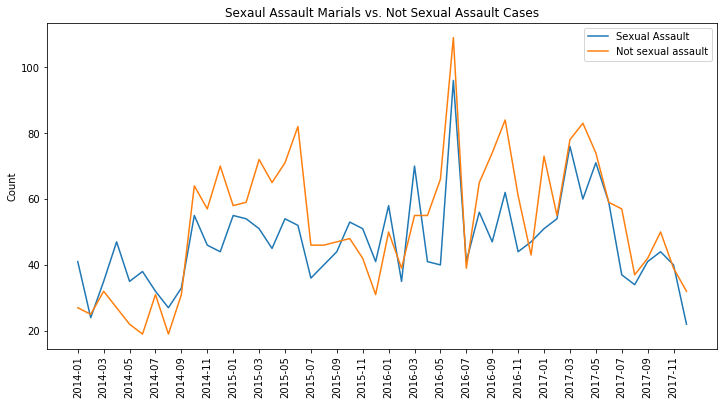

In [459]:
%matplotlib inline
import matplotlib.pyplot as plt

t=  pd.concat([
    (summary_full
     [summary_full['Year'].isin(['2014', '2015', '2016', '2017'])]
     [summary_full['Sexual-assault?'] ==True]
     ['Date-clean']
     .value_counts()
     .to_frame('Sexual Assault')
    ).sort_index(),
    (summary_full
     [summary_full['Year'].isin(['2014', '2015', '2016', '2017'])]
     [summary_full['Sexual-assault?'] ==False]
     ['Date-clean']
     .value_counts()
     .to_frame('Not sexual assault'))
    .sort_index()
], axis=1)

t.plot(figsize=(12,6))
plt.xticks(range(len(t))[::2], list(t.index)[::2], rotation='vertical')
plt.title('Sexaul Assault Marials vs. Not Sexual Assault Cases')
plt.ylabel('Count');

/Users/206309/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/206309/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


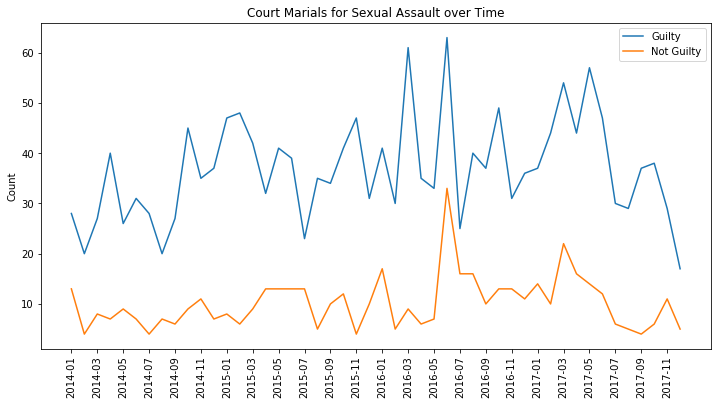

In [449]:
%matplotlib inline
import matplotlib.pyplot as plt

t=  pd.concat([
    (summary_sex_assault_full
     [summary_sex_assault_full['Year'].isin(['2014', '2015', '2016', '2017'])]
     [summary_sex_assault_full['Conclusion'] =='guilty']
     ['Date-clean']
     .value_counts()
     .to_frame('Guilty')
    ).sort_index(),
    (summary_sex_assault_full
     [summary_sex_assault_full['Year'].isin(['2014', '2015', '2016', '2017'])]
     [summary_sex_assault_full['Conclusion'] =='not guilty']
     ['Date-clean']
     .value_counts()
     .to_frame('Not Guilty'))
    .sort_index()
], axis=1)

t.plot(figsize=(12,6))
plt.xticks(range(len(t))[::2], list(t.index)[::2], rotation='vertical')
plt.title('Court Marials for Sexual Assault over Time')
plt.ylabel('Count');

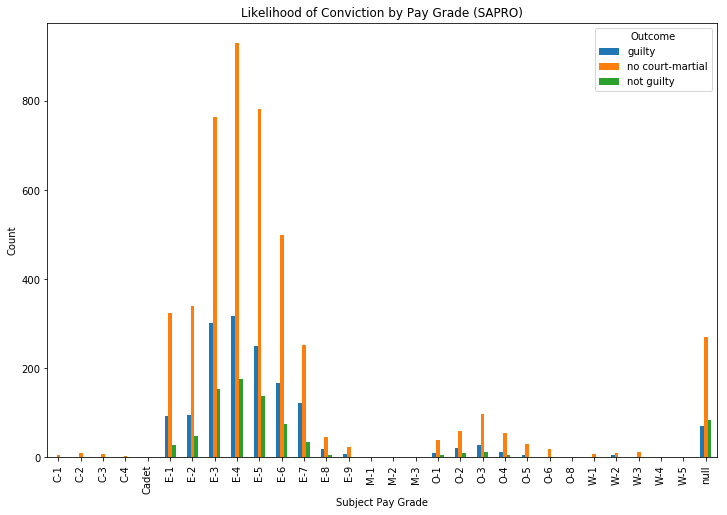

In [364]:
to_drop = ['Cadet/Mid shipman', 'Foreign National', 'Subject Pay Grade', 'UNKNOWN', 'Unknow','Unknown','US Civilian']
(sapro_full
 [['Subject Pay Grade', 'Outcome']]
 .assign(c=1)
 .pivot_table('c', 'Subject Pay Grade', 'Outcome', aggfunc='sum')
 .sort_index()
 .drop(to_drop)
 .plot(kind='bar', figsize=(12,8))
)
plt.title('Likelihood of Conviction by Pay Grade (SAPRO)')
plt.ylabel('Count');

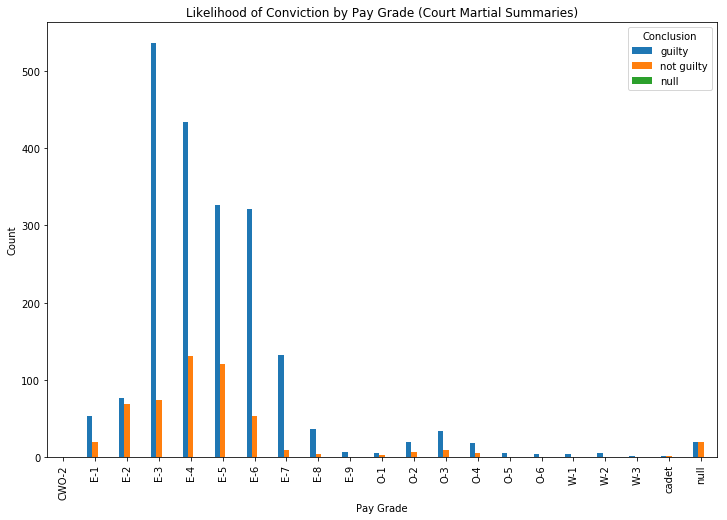

In [460]:
conviction_by_pay_grade = (summary_sex_assault_full
 [['Pay Grade', 'Conclusion']]
 .assign(c=1)
 .pivot_table('c', 'Pay Grade', 'Conclusion', aggfunc='sum')
#  .pipe(lambda df: df.fillna(0))
#  .pipe(lambda df: df['guilty'] / (df['guilty'] + df['not guilty']) )
 .sort_index())
conviction_by_pay_grade.plot(kind='bar', figsize=(12,8))

plt.title('Likelihood of Conviction by Pay Grade (Court Martial Summaries)')
plt.ylabel('Count');

In [475]:
summary_full['Paragraph'].fillna('').apply(lambda x: 'retail' in x).value_counts()

False    5306
Name: Paragraph, dtype: int64

In [462]:
from scipy.stats import chi2_contingency

print 'Likelihood of this happening by chance:'
print chi2_contingency( conviction_by_pay_grade[['guilty', 'not guilty']].fillna(0))[1]
# )

Likelihood of this happening by chance:
1.2235367816257164e-24


In [468]:
sapro_full[[
    'Must Register as Sex Offender',
    'Administrative Discharge Type',
    'Adverse Administrative Action Type',
    'Extra Duty',
    'Fines and Forfeiture s',
    'Hard Labor'
]].head(10)

,Must Register as Sex Offender,Administrative Discharge Type,Adverse Administrative Action Type,Extra Duty,Fines and Forfeiture s,Hard Labor
0,null,General,null,YES,YES,null
1,null,General,null,null,null,null
2,null,General,null,null,null,null
3,null,Pending,null,null,null,null
4,null,Uncharacterized,null,null,null,null
5,null,Uncharacterized,null,null,null,null
6,null,UOTHC,null,null,null,null
7,null,General,null,null,null,null
8,null,General,null,null,null,null
9,null,General,null,YES,YES,null


In [401]:
to_drop = ['null', u'First Class', u',', u'(E-2)', u'First Class,', '2']
repeats = (summary_sex_assault_full
           .groupby('Name')['Conclusion']
           .apply(lambda x: x.value_counts())
           .drop(to_drop)
           .sort_values(ascending=False)
          )

In [425]:
(summary_sex_assault_full
 [summary_sex_assault_full
  .Name
  .isin(repeats[repeats > 1].reset_index()['Name'])
 ]
).drop_duplicates('Orig-Par').pipe(
    lambda df: df[df['Name'].isin(df['Name'].value_counts().pipe(lambda s: s[s >= 2].index))])[['Orig-Par']].values

array([[u'At Beale AFB, CA, Senior Airman Marcus A. Mancini was found guilty by officer and \nenlisted members of sexual assault, abusive sexual contact, and assault consummated by battery.  \nHe was sentenced a dishonorable discharge, confinement for 9 years, reduction to Airman Basic \n(E-1), and total forfeiture of all pay and allowances. \n\nGeneral Court-Martial Acquittals'],
       [u'At Charleston AFB, SC, Senior Airman Alexzander L. Rossi was found guilty by military \njudge alone of attempted sexual assault of a child and attempted sexual abuse of a child. He was \nsentenced to reduction to Airman Basic (E-1), a dishonorable discharge, and confinement for \n15 months. Pursuant to a pretrial agreement, the convening authority will not approve \nconfinement in excess of 12 months.'],
       [u'At JB Charleston, SC, Senior Airman Alexzander L. Rossi was found guilty by a military \njudge of attempted sexual assault of a child and attempted sexual abuse of a child. He was \nsenten

In [428]:
sapro_full['Subject: Prior Investigation for Sex Assault?'].value_counts()

No                                               5045
null                                             3107
Yes                                               133
YES                                                77
Subject: Prior Investigation for Sex Assault?       1
Name: Subject: Prior Investigation for Sex Assault?, dtype: int64